# Predicting Extreme Weather Events using Gradient Boost

WiDS Datathon Overview:

"The WiDS Datathon 2023 focuses on a prediction task involving forecasting sub-seasonal temperatures (temperatures over a two-week period, in our case) within the United States. We are using a pre-prepared dataset consisting of weather and climate information for a number of US locations, for a number of start dates for the two-week observation, as well as the forecasted temperature and precipitation from a number of weather forecast models (we will reveal the source of our dataset after the competition closes). Each row in the corresponds to a single location and a single start date for the two-week period. Your task is to predict the arithmetic mean of the maximum and minimum temperature over the next 14 days, for each location and start date.

You are provided with two datasets:

`train_data.csv`: the training dataset, where `contest-tmp2m-14d__tmp2m`, the arithmetic mean of the max and min observed temperature over the next 14 days for each location and start date, computed as (measured max temperature + measured mini temperature) / 2".
`test_data.csv`: the test dataset, where we withhold the true value of `contest-tmp2m-14d__tmp2m` for each row".

We've done some initial investigation and visualization withing EDA previously and came to the conclusion that the dataset is fairy complicated and there are no obvious clues on how to manually select features without proper domain knowledge. One obvious issue for potential feature selection that we've been able to find is increase of temperatures in the testing set, compared to training set due to climate change. Considering that this issue can cause data drift we are going to try to mitigate this issue using Adversarial Validation. For prediction itself we are going to try using gradient boosting model, which is quite resilient to outliers and overfitting - CatBoost (https://arxiv.org/abs/1810.11363) and for hyperparameter optimisation we are going to use Bayesian Optimizer (https://en.wikipedia.org/wiki/Bayesian_optimization).



In [2]:
# Basic imports related to analysis
import pandas as pd
import numpy as np
import os

# Imports for visualisation
import umap.plot

# ML related imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import Pool, cv, CatBoostRegressor
from bayes_opt import BayesianOptimization
import bayes_opt
from sklearn.model_selection import * 
from sklearn.metrics import *
import lightgbm as lgb
import shap


# Imports related to preprocessing
from preprocessing import location_nom
from preprocessing import parse_start_date
from preprocessing import categorical_encode
from preprocessing import with_nans

# Silence warnings
import warnings
warnings.filterwarnings("ignore")


## Reading Dataset

Let's start by importing some libraries and loading CSVs into a DataFrames.

In [2]:
# Display all content of the columns
pd.set_option('display.max_columns', None)

# Upload data
train_data = pd.read_csv('datasets/train_data.csv')
test_data = pd.read_csv('datasets/test_data.csv')
submit = pd.read_csv('datasets/sample_solution.csv')

# Save target 
target = 'contest-tmp2m-14d__tmp2m'

Let's check how many data points and columns each set contains.

In [3]:
print(f'Train_shape: {train_data.shape}    |  Test_shape: {test_data.shape}')

Train_shape: (375734, 246)    |  Test_shape: (31354, 245)


Now let's check how the data looks. 

In [4]:
# Display part of the trainig set
train_data.head(5)

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

In [5]:
# Display part of the testing set
test_data.head(5)

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,w

In [6]:
submit.head(5)

,contest-tmp2m-14d__tmp2m,index
0,27.073876,375734
1,25.109308,375735
2,22.557390,375736
3,25.572875,375737
4,20.781073,375738


## Preprocessing Dataset

During our EDA investigation we've figured out that longitude and latitude values differ for several meters, but can be associated with essentially the same locations. The last digits of fractional parts of some values were different, so we truncated them to 6 digits after coma, so latitude and longitude in training and testing sets match as they, de facto, do. We are going to do the same here as well as create location groups as additional feature for the model. 

In [7]:
# Truncate coordinates and add groups
train_data, test_data = location_nom(train_data, test_data)

# Check location groups
train_data.loc_group, test_data.loc_group

(0           0
 1           0
 2           0
 3           0
 4           0
          ... 
 375729    513
 375730    513
 375731    513
 375732    513
 375733    513
 Name: loc_group, Length: 375734, dtype: int64,
 0          0
 1          0
 2          0
 3          0
 4          0
         ... 
 31349    513
 31350    513
 31351    513
 31352    513
 31353    513
 Name: loc_group, Length: 31354, dtype: int64)

As we've figured out in EDA `NaN` values are present only in the testing set. In EDA we've used previous value to fill the next missing value, but one partecipant found a different solution to this issue. There are 8 columns with missing values:

In [8]:
with_nans(train_data)

nmme0-tmp2m-34w__ccsm30    15934
nmme-tmp2m-56w__ccsm3      10280
nmme-prate-34w__ccsm3       8738
nmme0-prate-56w__ccsm30    15934
nmme0-prate-34w__ccsm30    15934
nmme-prate-56w__ccsm3      10280
nmme-tmp2m-34w__ccsm3       8738
ccsm30                     15934
dtype: int64

According to the data description: "nmme0-tmp2m-34w": file containing most recent monthly NMME model forecasts for `tmp2m` (`cancm30,cancm40, ccsm30, ccsm40, cfsv20, gfdlflora0, gfdlflorb0, gfdl0, nasa0, nmme0mean`) and average forecast across those models (`nmme0mean`)". 

This means that: `nmme0mean = (missing + cancm30 + cancm40 + ccsm30 + ccsm40 + cfsv20 + gfdlflora0 + gfdlflorb0 + gfdl0 + nasa0) / 9`

So basically we can find missing values like that: `missing = (nmme0mean * 9) - (cancm30 + cancm40 + ccsm40 + cfsv20 + gfdlflora0 + gfdlflorb0 + gfdl0 + nasa0)`

Considering that almost each missing column has associated list of columns that contain similar values and column that contain their mean, we can do this operation for each column from the mising list.


In [9]:
from preprocessing import groups, group_na, group_means

zip_cols = zip(group_na, groups, group_means)
for c, g, m in zip_cols:
    train_data[c] = (train_data[m]*9) - train_data[g].sum(1)

For one column that is left we can apply the old method, used in EDA. 

In [10]:
# Replace each `NaN` with the value that stands right before it
def fill_na(df):
    df = df.sort_values(by=['startdate', 'loc_group']).ffill()
    return df

train_data = fill_na(train_data)

# Check if any `NaN`s are left
with_nans(train_data)

No NaN values found.


Now let's deal with the `startdate`. We are going to change its data type and split it into 3 columns `year`, `month`, `day`. 

In [11]:
parse_start_date(train_data)
parse_start_date(test_data)[:2]

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,w

In [12]:
# Check the resulting data type
train_data.startdate.dtype, test_data.startdate.dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'))

In [13]:
# Check the year column
train_data.year, test_data.year

(122       2015
 853       2015
 1584      2015
 2315      2015
 3046      2015
           ... 
 372452    2015
 373183    2015
 373914    2015
 374645    2015
 375376    2015
 Name: year, Length: 375734, dtype: int32,
 0        2022
 1        2022
 2        2022
 3        2022
 4        2022
          ... 
 31349    2022
 31350    2022
 31351    2022
 31352    2022
 31353    2022
 Name: year, Length: 31354, dtype: int32)

Since there are not many unique regions we'll try to encode them to feel a bit more free with visualization. It's not guaranteed though that models will perform better with regions encoded that simple, but to make the coding more accurate we need to know the intrinsic relationship between regions and extreme weather events.  

In [14]:
categorical_encode(train_data, test_data)
train_data.climateregions__climateregion.unique()

array([ 0,  4,  1,  3,  2,  6,  7,  5,  9, 12, 10,  8, 11, 13, 14])

Let's create out sets for Adversarial validation. 

In [15]:
def create_sets(train, test, drop_cols):
    features = [col for col in train.columns if col not in drop_cols]
    X = train[features]
    X_test = test[features]
    y = train[target]
    
    return X, y, X_test

X, y, X_test = create_sets(
    train_data.copy(), 
    test_data.copy(),
    drop_cols = ['index', 'startdate', 'lat', 'lon', target]
    )


## Train and Validation

We will have 3 sets total train, validation and test.

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'Train_shape: {X_train.shape}    |   Val_shape: {X_val.shape}    |   Test_shape: {X_test.shape}')

Train_shape: (251741, 245)    |   Val_shape: (123993, 245)    |   Test_shape: (31354, 245)


If the feature distributions in the training and test datasets are different, as in our case, the
performance on the validation and test datasets will be different. The adversarial validation helps to detect the difference between the training and test datasets. In adversarial validation we train binary classifier (adversarial classifier) to predict if a data point belongs to the train or test dataset.

"If distributions of the features from the train and test data are similar, we expect the adversarial classifier to be as good as random guesses. However, if the adversarial classifier can distinguish between training and test data well (i.e. AUC score ≫ 50%), the top features from the adversarial classifier are potential candidates exhibiting concept drift between the train and test data. We can then
exclude these features from model training".

In [19]:
# combine train & test features, create label to identify test vs train
labels = np.array([1]*X.shape[0] + [0]*X_test.shape[0])
df_master = pd.concat([X, X_test])
df_master['labels'] = labels
df_sample = df_master.sample(30000)
labels = df_sample['labels'].values
df_master = df_sample.drop('labels', axis=1)

Before training the model let's check how training and testing data points distribution looks on the UMAP (Uniform Manifold Approximation and Projection).

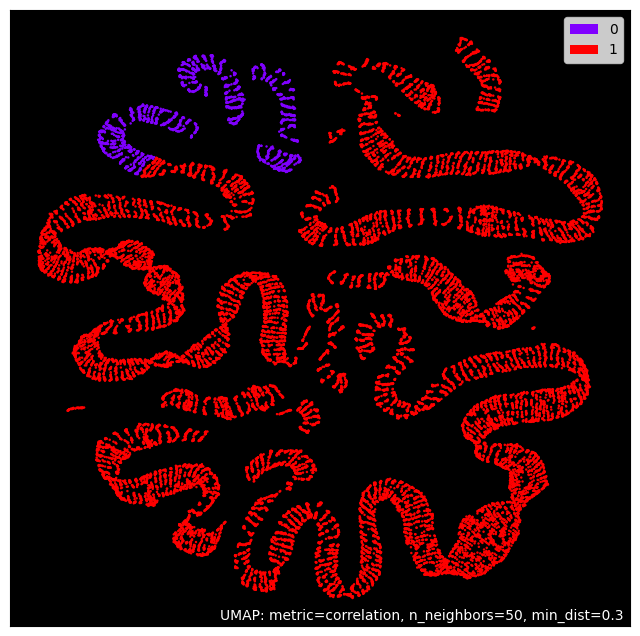

In [20]:
def plot_umap_for_dataset(df_master, labels , n_neighbors, min_dist):
    mapper = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric='correlation').fit(df_master.values)
    umap.plot.points(mapper, labels=labels, theme='fire')

plot_umap_for_dataset(df_master, labels, n_neighbors=50, min_dist=0.3)

UMAP successfully distinguished testing and training sets and we can see clear clusters, let's see how adversarial classifier will do that. 

In [21]:
def run_adversial_validation(train_X_ml, test_X_ml):
    
    lgb_params = {'n_estimators':100,
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'verbose': -1,
                'force_col_wise' : 'True'
                }
    
    # combine train & test features, create label to identify test vs train
    ad_y = np.array([1]*train_X_ml.shape[0] + [0]*test_X_ml.shape[0])
    ad_X = pd.concat([train_X_ml, test_X_ml])

    # evaluate model performance using cross-validation
    lgb_data = lgb.Dataset(ad_X, ad_y)
    cv_lgb = lgb.cv(lgb_params, lgb_data)

    print("Adversarial Validation AUC Score: {}".format(cv_lgb['auc-mean'][-1]))
    
    # train model & get feature importance
    ad_val_mod = lgb.train(lgb_params, lgb_data)

    df = pd.DataFrame(
        {'feat':ad_X.columns, 
         'imp':ad_val_mod.feature_importance('split')}).sort_values('imp', ascending = False)   
    
    return ad_val_mod, df

ad_val_mod, imp_df = run_adversial_validation(X, X_test)
imp_df

Adversarial Validation AUC Score: 1.0


,feat,imp
0,contest-pevpr-sfc-gauss-14d__pevpr,239
1,nmme0-tmp2m-34w__cancm30,107
242,year,100
2,nmme0-tmp2m-34w__cancm40,41
11,contest-wind-h10-14d__wind-hgt-10,22
...,...,...
135,wind-uwnd-250-2010-20,0
136,mjo1d__phase,0
48,nmme0-prate-34w__cfsv20,0
138,mei__mei,0


Top 3 columns ( `'contest-pevpr-sfc-gauss-14d__pevpr','nmme0-tmp2m-34w__cancm30', 'year'`) have the maximum impact, so we'll try to remove them to make prediction better. For `year` feature it is more or less clear result, because years are distinctively different, but for other features not. So there is no guarantee that performance will become better, because AUC score is crazy high, and we don't really know in depth what data plays which role in this dataset. We'll try to test the model with and without those features to be sure. 

In [22]:
X_train_dropped = X_train.drop(['contest-pevpr-sfc-gauss-14d__pevpr','nmme0-tmp2m-34w__cancm30', 'year'], axis=1)
X_val_dropped = X_val.drop(['contest-pevpr-sfc-gauss-14d__pevpr','nmme0-tmp2m-34w__cancm30', 'year'], axis=1)
X_test_dropped = X_test.drop(['contest-pevpr-sfc-gauss-14d__pevpr','nmme0-tmp2m-34w__cancm30', 'year'], axis=1)

## Building CatBoost Model

For quality estimation we'll use Root Mean Squared Error.

In [23]:
cb_params = {'iterations': 25000,
            'learning_rate': 0.01,
            'depth': 6,
            'l2_leaf_reg': 3,
            'bagging_temperature': 0,
            'border_count': 128,
            'loss_function': 'RMSE',
            'random_seed': 42,
            'task_type': 'GPU',
            'verbose': 500}

In [24]:
def cat_boost_full():
    cat = CatBoostRegressor(**cb_params)
    cat.fit(Pool(X_train, y_train), eval_set=(X_val, y_val))
    print(cat.get_best_score())

cat_boost_full()

0:	learn: 9.7820461	test: 9.7773855	best: 9.7773855 (0)	total: 20.8ms	remaining: 8m 38s
500:	learn: 1.5450738	test: 1.5489650	best: 1.5489650 (500)	total: 8.5s	remaining: 6m 55s
1000:	learn: 1.2351966	test: 1.2414582	best: 1.2414582 (1000)	total: 17.1s	remaining: 6m 49s
1500:	learn: 1.0762950	test: 1.0842371	best: 1.0842371 (1500)	total: 25.5s	remaining: 6m 39s
2000:	learn: 0.9737550	test: 0.9832932	best: 0.9832932 (2000)	total: 34s	remaining: 6m 30s
2500:	learn: 0.8976588	test: 0.9084957	best: 0.9084957 (2500)	total: 42.4s	remaining: 6m 21s
3000:	learn: 0.8374680	test: 0.8490104	best: 0.8490104 (3000)	total: 50.8s	remaining: 6m 12s
3500:	learn: 0.7899530	test: 0.8024407	best: 0.8024407 (3500)	total: 59.2s	remaining: 6m 3s
4000:	learn: 0.7509259	test: 0.7643340	best: 0.7643340 (4000)	total: 1m 7s	remaining: 5m 54s
4500:	learn: 0.7176344	test: 0.7318607	best: 0.7318607 (4500)	total: 1m 16s	remaining: 5m 46s
5000:	learn: 0.6886753	test: 0.7035182	best: 0.7035182 (5000)	total: 1m 24s	rema

In [25]:
def cat_boost_dropped():
    cat = CatBoostRegressor(**cb_params)
    cat.fit(Pool(X_train_dropped, y_train), eval_set=(X_val_dropped, y_val))
    print(cat.get_best_score())

cat_boost_dropped()

0:	learn: 9.7818520	test: 9.7772742	best: 9.7772742 (0)	total: 18.5ms	remaining: 7m 41s
500:	learn: 1.5451394	test: 1.5474037	best: 1.5474037 (500)	total: 8.61s	remaining: 7m 1s
1000:	learn: 1.2293017	test: 1.2346061	best: 1.2346061 (1000)	total: 17.1s	remaining: 6m 49s
1500:	learn: 1.0720630	test: 1.0794832	best: 1.0794832 (1500)	total: 25.6s	remaining: 6m 40s
2000:	learn: 0.9719867	test: 0.9809140	best: 0.9809140 (2000)	total: 33.9s	remaining: 6m 29s
2500:	learn: 0.8972815	test: 0.9075141	best: 0.9075141 (2500)	total: 42.3s	remaining: 6m 20s
3000:	learn: 0.8384687	test: 0.8497995	best: 0.8497995 (3000)	total: 50.6s	remaining: 6m 11s
3500:	learn: 0.7895115	test: 0.8019658	best: 0.8019658 (3500)	total: 59.1s	remaining: 6m 2s
4000:	learn: 0.7506862	test: 0.7638532	best: 0.7638532 (4000)	total: 1m 7s	remaining: 5m 55s
4500:	learn: 0.7174343	test: 0.7313198	best: 0.7313198 (4500)	total: 1m 16s	remaining: 5m 47s
5000:	learn: 0.6882919	test: 0.7026675	best: 0.7026675 (5000)	total: 1m 24s	re

The removal of 3 features (`'contest-pevpr-sfc-gauss-14d__pevpr','nmme0-tmp2m-34w__cancm30', 'year'`) which allow classifier to distinguish between training and testing sets didn't give us any improvement in performance, so we'll live them be.

## Bayesian Optimization for CatBoost

We are going to use Baesian Optimizaton to find best parameters for our model. For quality estimation we'll use Root Mean Squared Error.

In [26]:
# Root Mean Squared Error Finder
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

In [27]:
def CB_opt(depth, learning_rate, subsample, l2_leaf_reg, model_size_reg): 
    scores = []

    reg = CatBoostRegressor(   
                                    verbose = 0,
                                    # iterations=10,
                                    # n_estimators = 10,
                                    learning_rate = learning_rate,
                                    subsample = subsample, 
                                    l2_leaf_reg = l2_leaf_reg,
                                    max_depth = int(depth),
                                    # num_leaves = int(num_leaves),
                                    random_state = 1212,
                                    grow_policy = "Lossguide",
                                    # max_bin = int(max_bin),  
                                    use_best_model = True, 
                                    # bootstrap_type='Bayesian',
                                    loss_function='RMSE',
                                    model_size_reg = model_size_reg
                                )

    reg.fit(X_train, y_train, eval_set = (X_val, y_val))
    y_pred = reg.predict(X_val)
    scores.append(rmse(y_val, y_pred))

    return 1/np.mean(scores)

# "n_estimators": (150,1200),
# "num_leaves": (100,150),
# "max_bin":(150,300),
pbounds = {
            "depth": (6, 7),
            "learning_rate": (0.09, 0.0980689972639084),
            "subsample":(0.7, 0.800000011920929),
            "l2_leaf_reg":(2,4),
            "model_size_reg": (0.48, 0.5)
}

optimizer = BayesianOptimization(f = CB_opt, pbounds = pbounds,  verbose = 2, random_state = 1212)

optimizer.set_gp_params(alpha = 1e-6)
optimizer.maximize(init_points = 7, n_iter = 30)

print(optimizer.max)

max_bo_params = optimizer.max['params']

max_bo_params

|   iter    |  target   |   depth   | l2_lea... | learni... | model_... | subsample |
-------------------------------------------------------------------------------------
| 1         | 2.143     | 6.245     | 3.609     | 0.09141   | 0.4994    | 0.7225    |
| 2         | 2.183     | 6.869     | 2.563     | 0.09585   | 0.495     | 0.7247    |
| 3         | 2.191     | 6.772     | 2.171     | 0.09719   | 0.4844    | 0.7934    |
| 4         | 2.141     | 6.091     | 3.615     | 0.09314   | 0.4989    | 0.7017    |
| 5         | 2.186     | 6.542     | 2.583     | 0.09693   | 0.4901    | 0.7719    |
| 6         | 2.167     | 6.311     | 2.531     | 0.09148   | 0.4864    | 0.7726    |
| 7         | 2.157     | 6.908     | 2.939     | 0.0909    | 0.4853    | 0.7682    |
| 8         | 2.202     | 6.126     | 3.025     | 0.09703   | 0.485     | 0.7274    |
| 9         | 2.172     | 6.923     | 2.652     | 0.09218   | 0.4885    | 0.7175    |
| 10        | 2.182     | 6.0       | 2.858     | 0.09

{'depth': 7.0,
 'l2_leaf_reg': 3.864967696391404,
 'learning_rate': 0.0980689972639084,
 'model_size_reg': 0.48,
 'subsample': 0.800000011920929}

We have our hyperparameters, now we can plug them into the CatBoost model. 

In [28]:
opt_params = {
    'iterations':25000,
    'verbose':0,
    'learning_rate' : max_bo_params['learning_rate'],
    'subsample' : max_bo_params['subsample'], 
    'l2_leaf_reg' : max_bo_params['l2_leaf_reg'],
    'max_depth' : int(max_bo_params['depth']), 
    'use_best_model' : True, 
    'loss_function' : 'RMSE',
    'model_size_reg' : max_bo_params['model_size_reg']
}

## catBoost Pool object
bst = CatBoostRegressor(**opt_params)
bst.fit(Pool(X_train, y_train), eval_set=(X_val, y_val), plot=False, silent=True)
print(bst.get_best_score())


{'learn': {'RMSE': 0.07334624960404566}, 'validation': {'RMSE': 0.15889541192826312}}


"In this section, we showcase a sample of SHAP explainability evaluation for our model. SHAP (Shapley Additive explanations) is a popular approach for providing model interpretability by measuring the contribution of each feature to a prediction. This enables us to identify which features have the greatest impact on our model's outputs, and how they are related to the predicted values. 

To perform the SHAP evaluation, we first generate a set of test data and extract the features we want to evaluate. We then use the SHAP library to compute the SHAP values for each feature, which represent the change in the predicted value as a result of changing the feature value while holding all other features constant. These values are visualized using a SHAP summary plot, which shows the features ranked by their importance and the direction of their impact on the predicted value. Through the SHAP summary plot, we can observe the top contributing features to our model's predictions, and how they are positively or negatively correlated with the output. This enables us to gain insights into the underlying relationships between the features and the target variable, improving our understanding of how our model makes its predictions. Overall, the SHAP explainability evaluation provides a valuable tool for gaining insights into the inner workings of our model and making informed decisions based on its outputs".



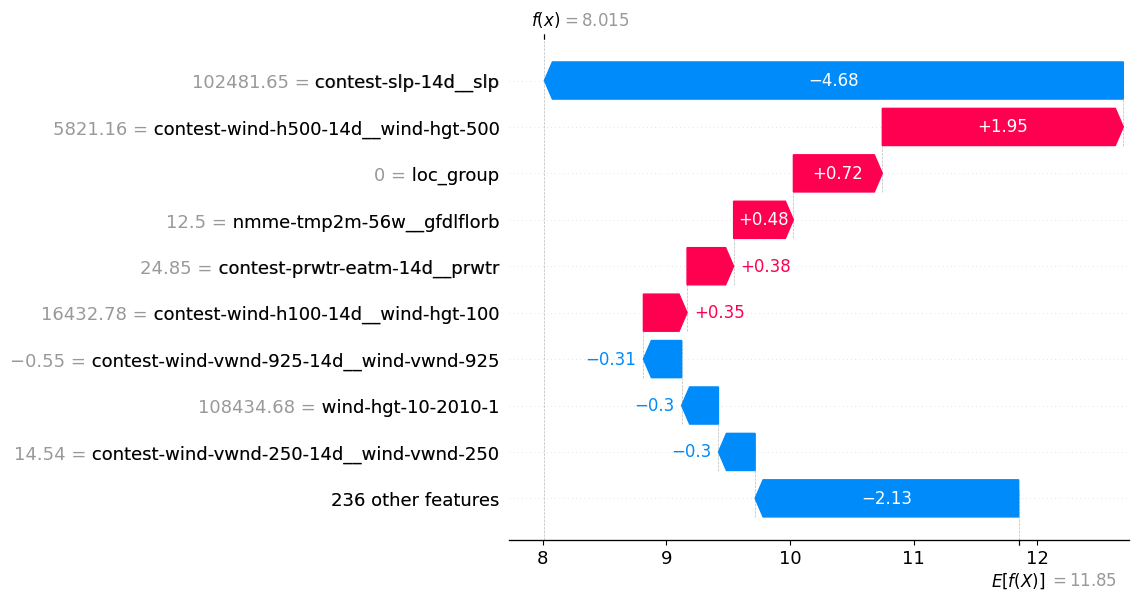

In [29]:
explainer = shap.Explainer(bst)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

Apparently, one of the most impactful features in this dataset are wind features.

Let's check our final temprerature predictions for this project. 

In [34]:
y_pred_cat = bst.predict(X_test)
y_pred_cat[:10]

array([29.18325369, 29.05571631, 28.90482478, 29.23015086, 29.11855108,
       28.99556615, 28.9143806 , 28.67569952, 28.39415152, 28.24202569])

In [35]:
submit_cat = submit.copy()
submit_cat[target] = y_pred_cat
submit_cat.to_csv('y_pred_cat.csv', index = False)

## Conclusion

- We've predicted the arithmetic mean of the maximum and minimum temperature over the next 14 days, for each location and start date using CatBoost model as a predictor and Bayesian Optimization as model's hyperparameter optimizator. The final RMSE score from the datathon organizers' test is `1.114`. 

- Adversarial validation has proven to be not very effective if removing only several features from the list of most important ones, so further investigation and more sophisticated approach is required. 

### References: 
- Adversarial Validation [arXiv:2004.03045v2](https://arxiv.org/abs/2004.03045)
- https://www.kaggle.com/code/kooaslansefat/wids-2023-woman-life-freedom#Bayesian-Optimization-for-CatBoost
- https://www.kaggle.com/code/ducnh279/find-x-correctly-impute-7-8-missing-value-columns
- https://machinelearningmastery.com/configure-gradient-boosting-algorithm/
- https://github.com/bayesian-optimization/BayesianOptimization/blob/master/examples/visualization.ipynb

